In [29]:
%matplotlib inline
import pandas as pd, numpy, statsmodels, bisect
from bisect import *
import scipy
from scipy import stats
import matplotlib.pyplot as plt

###Starting Values

In [30]:
# set number of buses below
number_of_buses = 3

# set number of stops
number_of_stops = 5

In [31]:
# set average speed of links in miles per hour
link_speeds_mph = [15,15,15,15,15,15]
link_speeds = [i/3600.0 for i in link_speeds_mph]

In [32]:
# set position of stops in miles
# last stop is the same as 0 (resets loop)
stop_spacing = 0.25
stop_positions = []
for i in range(number_of_stops):
    stop_positions.append((i+1)*stop_spacing)

# set buses to start evenly spaced between first and last stop
start_positions = []
start_spacing = stop_positions[-1]/number_of_buses
for i in range(number_of_buses):
    start_positions.append((i+1)*start_spacing - (start_spacing/2))

print "STARTING CONDITIONS"
print "# of buses: " + str(number_of_buses)
print "# of stops: " + str(number_of_stops)
print "link speeds array (miles per hour): " + str(link_speeds_mph)
print "link speeds array (miles per second): " + str(["{0:.5f}".format(i) for i in link_speeds])
print "stop positions (miles): " + str(stop_positions)
print "bus start positions: " + str(["{0:.2f}".format(i) for i in start_positions])

STARTING CONDITIONS
# of buses: 3
# of stops: 5
link speeds array (miles per hour): [15, 15, 15, 15, 15, 15]
link speeds array (miles per second): ['0.00417', '0.00417', '0.00417', '0.00417', '0.00417', '0.00417']
stop positions (miles): [0.25, 0.5, 0.75, 1.0, 1.25]
bus start positions: ['0.21', '0.62', '1.04']


In [33]:
# check number of stops correct
if len(stop_positions) != number_of_stops:
    print "number of stops incorrect"
else: print "number of stops OK"
    
# check number of links correct
if len(link_speeds) - 1 != number_of_stops:
    print "number of links incorrect"
else: print "number of links OK"

number of stops OK
number of links OK


### Dataframe and Variables

In [34]:
# create dataframe

df = pd.DataFrame(index = [range(0,3600)])

In [35]:
# create bus position variables

pos_vars = []
for i in range(number_of_buses):
    varname = "pos_" + str(i)
    df[varname] = 0
    pos_vars.append(varname) # this creates a list of bus position variables for indexing later
    
# create variables that record what link the bus is on

link_vars = []
for i in range(number_of_buses):
    varname = "link_" + str(i)
    df[varname] = 0
    df[varname] = df[varname].astype(int)
    link_vars.append(varname)

# create variables to keep track of bus speed between links

speed_vars = []
for i in range(number_of_buses):
    varname = "speed_" + str(i)
    df[varname] = 0
    speed_vars.append(varname)
    
# create variables to keep track of the dwelltime of each bus

dwell_vars = []
for i in range(number_of_buses):
    varname = "dwell_" + str(i)
    df[varname] = 0
    dwell_vars.append(varname)

# create variables to record how many passengers have arrived at each stop

pax_vars = []
for i in range(number_of_stops):
    varname = "pax_" + str(i)
    df[varname] = 0
    pax_vars.append(varname)    
    
# create variables to keep track of how long buses will have to wait once they arrive at each stop

wait_vars = []
for i in range(number_of_stops):
    varname = "wait_" + str(i)
    df[varname] = 0.0
    wait_vars.append(varname)

In [ ]:
# create lists for analytics later


### Bus & Passenger Behavior Functions

#### Passenger Arrival Function
* Loops through each variable in pax_vars and generates new passengers through a Poisson process
* Set "lamb" as average # of passengers arriving per HOUR (as in lambda in Poisson PMF)
* Presupposes counter variable i running through dataframe row-by-row

In [36]:
def pax_arrival(lamb):
    for stop in range(len(pax_vars)):
        if i == 0: 
            df.loc[i,pax_vars[stop]] = 0
        else:
            df.loc[i,pax_vars[stop]] = df.loc[i-1,pax_vars[stop]] + numpy.random.poisson(lam=(lamb/3600.0),size=1)[0]

#### Dwelltime Function
* For each bus stop, keeps track of how much time the next bus to arrive there will have to dwell
* board_time is average time to board per passenger, in SECONDS
* Presupposes counter variable i running through dataframe row-by-row

In [37]:
def dwelltime(board_time):    
    for s in range(len(wait_vars)):
        board = numpy.random.normal(loc=2,scale=1)
        if i == 0: 
            df.loc[i,wait_vars[s]] = 0
        else:
            df.loc[i,wait_vars[s]] = df.loc[i,pax_vars[s]] * board

#### Bus Movement Function
* No parameters other than already established variables in the dataframe

In [38]:
def bus_movement():
    for bus in range(number_of_buses):
        if i == 0:
            
            # set position using start position list
            df.loc[i,pos_vars[bus]] = start_positions[bus]
            
            # find link from position using "bisect" function
            df.loc[i,link_vars[bus]] = bisect_right(stop_positions,start_positions[bus])
            
            # find link speed from list
            
            # why does this become a float?
            # df.loc[i,speed_vars[bus]] = link_speeds[df.loc[i,link_vars[bus]]]
            df.loc[i,speed_vars[bus]] = link_speeds[bus]
            
            # set starting dwelltimes to 0 so that buses "leave" right away
            df.loc[i,dwell_vars[bus]] = 0

        else:
            prev_pos = df.loc[i-1,pos_vars[bus]]
            prev_link = int(df.loc[i-1,link_vars[bus]])
            prev_speed = df.loc[i-1,speed_vars[bus]]
            prev_dwell = df.loc[i-1,dwell_vars[bus]]      
            
            if prev_pos + prev_speed >= stop_positions[-1]:
                reached_end = True
            else:
                reached_end = False
            
            if prev_pos + prev_speed >= stop_positions[prev_link]:
                reached_stop = True
            else:
                reached_stop = False
                
            
            # identify current link (if at stop, bus is on following link) 
            if reached_end == True:
                current_link = 0
                df.loc[i,link_vars[bus]] = current_link
            elif reached_stop == True:
                current_link = prev_link + 1
                df.loc[i,link_vars[bus]] = current_link  # get current link number from stop position list
            else: 
                current_link = prev_link
                df.loc[i,link_vars[bus]] = current_link
            
            # reset passenger count at stop to 0
            if reached_end == True:
                df.loc[i,pax_vars[current_link]] = 0  
            elif reached_stop == True:
                df.loc[i,pax_vars[current_link]] = 0
            
                
            # get speed from the link, generate new speed only if link updates
            if reached_end == True:
                df.loc[i,speed_vars[bus]] = link_speeds[current_link]
            elif reached_stop == True:
                df.loc[i,speed_vars[bus]] = link_speeds[current_link]
            else: 
                df.loc[i,speed_vars[bus]] = prev_speed

            # if bus has arrived at a stop, generate a dwelltime
            # if bus has been at a stop, keep it at the stop until dwelltime is reached
            if reached_end == True:
                df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
            elif reached_stop == True:
                df.loc[i,dwell_vars[bus]] = df.loc[i,wait_vars[current_link]]
            else: 
                df.loc[i,dwell_vars[bus]] = max(0, prev_dwell - 1)

            # if bus is not at a stop, proceed at established speed

            #if prev_pos >= stop_positions[prev_link + 1]:
            #   df.loc[i,pos_vars[bus]] = df.loc[i-1,pos_vars[bus]] + df.loc[i,speed_vars[bus]]  
            
            if reached_end == True:
                df.loc[i,pos_vars[bus]] = 0 + ((prev_pos + prev_speed) - stop_positions[-1])
            elif df.loc[i-1,dwell_vars[bus]] <= 1 :
                df.loc[i,pos_vars[bus]] = prev_pos + prev_speed
            else: 
                df.loc[i,pos_vars[bus]] = prev_pos

### Simulation and Plots

In [39]:
# Run all the functions 
# Loop over every row in the dataframe


for i in range(len(df)):
    
    # 100 pax per hour
    pax_arrival(lamb = 100)
    
    # 2 seconds per boarding pax
    dwelltime(board_time = 2)
    
    bus_movement()

In [40]:
df.head()

,pos_0,pos_1,pos_2,link_0,link_1,link_2,speed_0,speed_1,speed_2,dwell_0,...,pax_0,pax_1,pax_2,pax_3,pax_4,wait_0,wait_1,wait_2,wait_3,wait_4
0,0.208333,0.625000,1.041667,0,2,4,0.004167,0.004167,0.004167,0,...,0,0,0,0,0,0,0,0,0,0
1,0.212500,0.629167,1.045833,0,2,4,0.004167,0.004167,0.004167,0,...,0,0,0,0,0,0,0,0,0,0
2,0.216667,0.633333,1.050000,0,2,4,0.004167,0.004167,0.004167,0,...,0,0,0,0,0,0,0,0,0,0
3,0.220833,0.637500,1.054167,0,2,4,0.004167,0.004167,0.004167,0,...,0,0,0,0,0,0,0,0,0,0
4,0.225000,0.641667,1.058333,0,2,4,0.004167,0.004167,0.004167,0,...,0,0,0,0,0,0,0,0,0,0


#### Time-Space Diagram

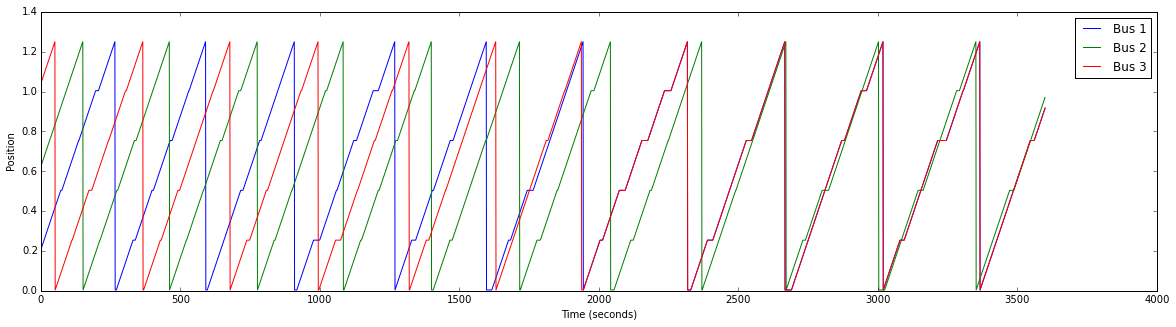

In [41]:
plt.figure(figsize=(20,5))
for i in pos_vars:
    plt.plot(df[i])
plt.ylabel('Position')
plt.xlabel('Time (seconds)')
plt.legend(["Bus 1","Bus 2","Bus 3"])
plt.show()

#### Cumulative Arrival Curves

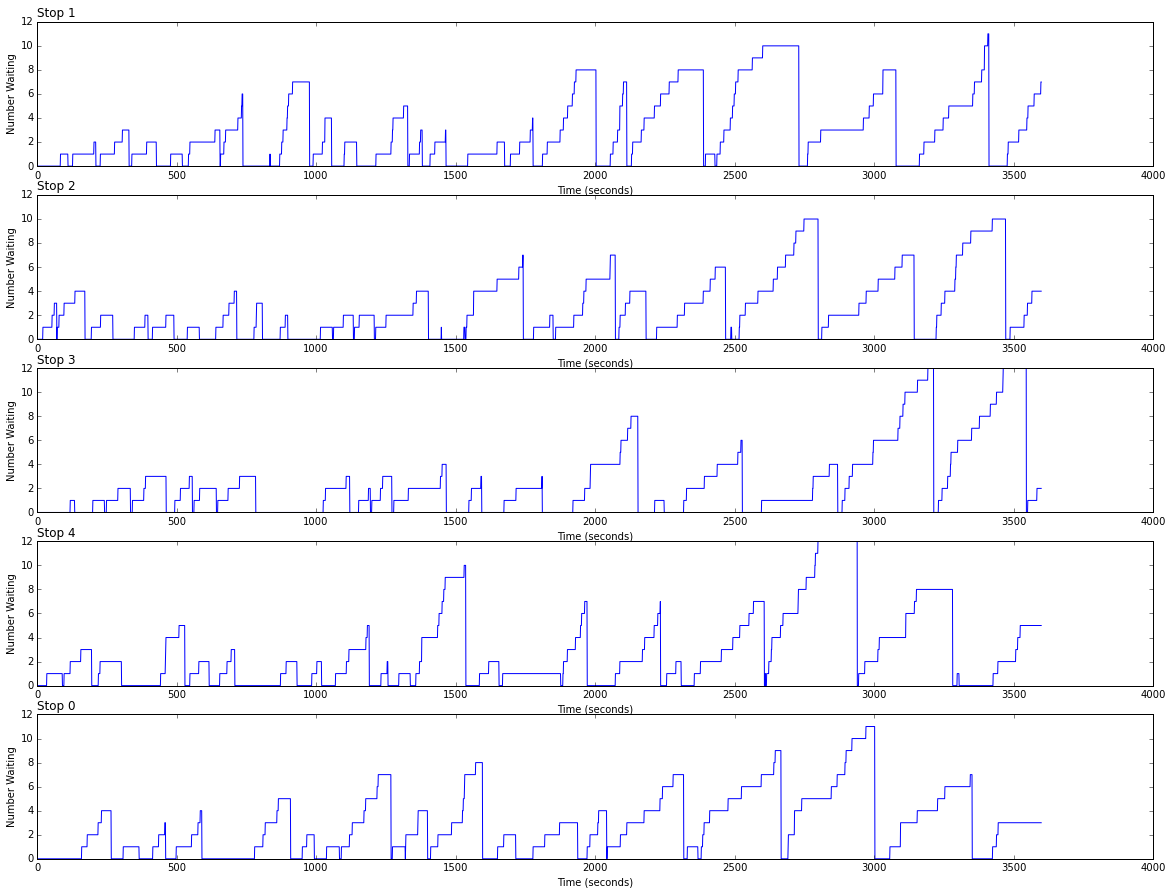

In [42]:
plt.figure(figsize=(20,15))
for i in pax_vars:
    plt.subplot(len(pax_vars),1,pax_vars.index(i))
    plt.title("Stop " + str(pax_vars.index(i)), loc="left")
    plt.plot(df[i])
    plt.ylabel('Number Waiting')
    plt.ylim(ymin = 0, ymax = 12)
    plt.xlabel('Time (seconds)')
plt.show()